In [1]:
# %autoreload 2

import sys
sys.path.append("../")

import os
import yaml
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
import matplotlib.gridspec as gridspec
plt.rcParams["font.family"] = "Optima"
plt.rcParams["font.weight"] = "light"

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import arviz as az
import textwrap
import json

from epimodel.preprocessing.preprocess_mask_data import Preprocess_masks
from epimodel.plotting.intervention_plots import combine_npi_samples
cols = sns.color_palette('colorblind')

def create_grouping(info_dict):
    grouped_reductions = []
    if 'CMReduction' in info_dict.keys():
        grouped_reductions.append('CMReduction')
    if 'MobilityReduction' in info_dict.keys():
        grouped_reductions.append('MobilityReduction')
    if 'WearingReduction' in info_dict.keys():
        grouped_reductions.append('WearingReduction')
    if 'MandateReduction' in info_dict.keys():
        grouped_reductions.append('MandateReduction')

    return grouped_reductions

def combine_reductions(info_dict):
    grouped_reductions = create_grouping(info_dict)

    reduction = np.array(info_dict[grouped_reductions[0]])
    if len(reduction.shape) == 1:
        reduction = reduction.reshape((list(reduction.shape)[0], 1))
    # print(reduction)
    # initialise to first reduction
    all_reductions = reduction
    if len(grouped_reductions) > 1:
        for reduction in grouped_reductions[1:]:
            transformed_reduction = np.array(info_dict[reduction])
            if len(transformed_reduction.shape) == 1:
                transformed_reduction = transformed_reduction.reshape((list(transformed_reduction.shape)[0], 1))
            # print(transformed_reduction)
            all_reductions = np.concatenate((all_reductions, transformed_reduction), axis=1)

    info_dict['All_CM_Reductions'] = all_reductions

    return info_dict

def intervention_prior_labeler(d):
    if float(d['exp_config']['intervention_prior']['scale']) == 20.0:
        return  "AsymmetricLaplace(0, 0.5, 20)"
    elif d['exp_config']['intervention_prior']['type'] == "normal":
        return f"Normal(0, {d['exp_config']['intervention_prior']['scale']}$^2$)"
    elif float(d['exp_config']['intervention_prior']['scale']) == 0.15:
        return "HalfNormal(0, 0.15$^2$)"

def get_all_experiments(path):
    experiments = []
    for subdir, dirs, files in os.walk(f'{path}'):
        i = 0
        for filename in files:
            if filename.endswith('.json') and i < 3:
                filepath = subdir + os.sep + filename
                print(filepath)
                with open(filepath) as f:
                    try:
                        data = json.load(f)
                        new_exp = combine_reductions(data)
                        experiments.append(new_exp)
                        print(f"Divergences: {np.sum(new_exp['divergences'])/len(new_exp['divergences'])}")
                        summary = new_exp['summary']
                        r_hats = [l[-1] for l in summary]
                        bad_r_hat_inds = [i for i in range(len(r_hats)) if r_hats[i] >= 1.05]
                        print(f'There are {len(bad_r_hat_inds)} parameters with r_hat > 1.05')
                    except Exception as e:
                        print(e)
                        print(f'failed to load {f}')
            i += 1
    print(len(experiments))
    return experiments

def filter_by_exp_tag(experiments, exp_tag):
    filtered = []
    for experiment in experiments:
        if experiment['exp_tag'] == exp_tag:
                    filtered.append(experiment)
    return filtered


all_exp_info = {
    "default": {
        "title": "Default",
        "labeler": "",
        "default_label": "Default"
    },
    # "basic_R_prior_mean": {
    #     "title": "$\\tilde{R}_{0, l}$ Prior: Mean",
    #     "labeler": lambda d: d['exp_config']["basic_R_prior"]["mean"],
    #     "default_label": "Default (1.1)"
    # },
    "basic_R_prior_scale": {
        "title": "$\\tilde{R}_{0, l}$ Prior: Variability Scale",
        "labeler": lambda d: d['exp_config']["basic_R_prior"]["noise_scale"],
        "default_label": "Default (0.4)"
    },
    "basic_R_hyperprior_mean_mean": {
        "title": "$\\tilde{R}_{0, l}$ Prior: Mean Mean",
        "labeler": lambda d: d['exp_config']["basic_R_prior"]["mean_mean"],
        "default_label": "Default (1.07)"
    },
    "basic_R_hyperprior_mean_scale": {
        "title": "$\\tilde{R}_{0, l}$ Prior: Mean Scale",
        "labeler": lambda d: d['exp_config']["basic_R_prior"]["mean_scale"],
        "default_label": "Default (0.5)"
    },
    # "basic_R_hyperprior_var_scale": {
    #     "title": "$\\tilde{R}_{0, l}$ Prior: Variability Scale",
    #     "labeler": lambda d: d['exp_config']["basic_R_prior"]["mean_scale"],
    #     "default_label": "Default (0.3)"
    # },
    "cases_delay_mean": {
        "title": "Mean Delay from Infection to Case Reporting",
        "labeler": lambda d: f"{float(d['exp_config']['cases_delay_mean'])} days",
        "default_label": "Default (10.0 days)"
    },
    "gen_int_mean": {
        "title": "Generation Interval Mean",
        "labeler": lambda d: f"{float(d['exp_config']['gen_int_mean'])} days",
        "default_label": "Default (5.0 days)"
    },
    "r_walk_noise_scale_prior": {
        "title": "Random Walk Noise Scale Prior",
        "labeler": lambda d: f"HalfNormal({float(d['exp_config']['r_walk_noise_scale_prior']):.2f})",
        "default_label": "Default (HalfNormal(0.15))"
    },
    "npi_leaveout": {
        "title": "NPI Leaveout",
        # "labeler": lambda d: f"{textwrap.fill(corrected_names[d['exp_config']['npis'][0]], 15)}",
        "labeler": lambda d: f"{d['exp_config']['npis'][0]}",
        "default_label": "Default"
    },
    "r_walk_period": {
        "title": "Random Walk Period",
        "labeler": lambda d: f"{d['exp_config']['r_walk_period']} days",
        "default_label": "Default (7 days)"
    },
    "intervention_prior": {
        "title": "Intervention Effect Prior",
        "labeler": intervention_prior_labeler,
        "default_label": "AsymmetricLaplace(0, 0.5, 30)"
    },
    "boostrap": {
        "title": "Bootstrap",
        "labeler": lambda d: "Bootstrapped",
        "default_label": "Default"
    },
    # "mandates": {
    #     "title": "Mask Mandates",
    #     "labeler": lambda d: "Mandates",
    #     "default_label": "Wearing"
    # },
    "mask_sigma": {
        "title": "Mask Prior Scale",
        "labeler": lambda d: f"{d['exp_config']['mask_sigma']}",
        "default_label": "Default (0.4)"
    },
    "wearing_parameterisation": {
        "title": "Wearing Parameterisation",
        "labeler": lambda d: f"{d['exp_config']['wearing_parameterisation']}",
        "default_label": "Exponential"
    },
    "wearing_prior_scale": {
        "title": "Wearing Prior Scale",
        "labeler": lambda d: f"{d['exp_config']['wearing_sigma']}",
        "default_label": "Default (0.4)"
    },
    "mobility_sigma": {
        "title": "Mobility Intervention Prior Scale",
        "labeler": lambda d: f"{d['exp_config']['mobility_sigma']}",
        "default_label": "Default (0.5)"
    },
    "mobility_leaveout": {
        "title": "Mobility Leaveout",
        "labeler": lambda d: f"No mobility",
        "default_label": "Mobility"
    },
    "cases_delay_disp_mean": {
        "title": "Case Delay Dispersion",
        "labeler": lambda d: f"{d['exp_config']['cases_delay_disp_mean']}",
        "default_label": "Default (5)"
    },
    "mob_and_wearing_only": {
        "title": "Mobility and Wearing Only",
        "labeler": lambda d: f"Mob & Wearing Only",
        "default_label": "Default"
    },
    "mobility_mean": {
        "title": "Mobility Intervention Prior Mean",
        "labeler": lambda d: f"{d['exp_config']['mobility_mean']}",
        "default_label": "Default (1)"
    },
    "fake_wearing_npi": {
        "title": "Linear Increase Wearing NPI",
        "labeler": lambda d: f"Fake Wearing NPI",
        "default_label": "Default"
    },
    "window_of_analysis": {
        "title": "Window of Analysis",
        "labeler": lambda d: f"{d['exp_config']['start_date']} to {d['exp_config']['end_date']}",
        "default_label": "Default"
    },
    "mask_leave_on": {
        "title": "Mandate Leave-on",
        "labeler": lambda d: f"Mandate Leave-on",
        "default_label": "Default"
    },
    "mask_thresholds": {
        "title": "Number of Mandates",
        "labeler": lambda d: f"2",
        "default_label": "Default (1)"
    },
    'everything_normalised': {
        "title": "All data shifted to 0 at start of window",
        "labeler": lambda d: f"Shifted",
        "default_label": "Default (wearing % not shifted)"
    }
}

class experiment_type():
    def __init__(self, experiments, exp_info, tag):
        self.exp_info = exp_info
        self.experiments = experiments
        self.exp_info["tag"] = tag

        if "All_CM_Reductions" in list(self.experiments[0].keys()):
            self.experiments.sort(key=lambda x: np.median(np.array(x['All_CM_Reductions'])[:, 0]))

def get_unique_exp_tags(experiments):
    return list(np.unique([exp['exp_tag'] for exp in experiments]))

def make_all_experiment_classes(all_experiments):
    tags = get_unique_exp_tags(all_experiments)
    classes = []
    for tag in tags:
        filtered_exps = filter_by_exp_tag(all_experiments, tag)
        if tag in all_exp_info.keys():
            exp_info = all_exp_info[tag]
            classes.append(experiment_type(filtered_exps, exp_info, tag))
        else:
            print(f"{tag} was skipped")

    return classes

# corrected_names = [
#     'Night clubs closed',
#     'Gastronomy closed',
#     'Leisure venues closed',
#     'Retail and close-contact\nservices closed',
#     'Night time curfew',
#     'Primary schools closed',
#     'Secondary schools closed',
#     'Universities closed',
#     'All public gatherings banned',
#     'Public gatherings limited to 2 people',
#     'Public gatherings limited to ≤10 people',
#     'Public gatherings limited to ≤30 people',
#     'Public gatherings limited to 2 households',
#     'All household mixing in private banned',
#     'Household mixing in private limited to 2 people',
#     'Household mixing in private limited to ≤10 people',
#     'Household mixing in private limited to ≤30 people',
#     'Household mixing in private limited to 2 households',
#     'Stricter mask-wearing\npolicy',
# ]

grouped_npis = {
    'School closing': {
        'npis': ['C1_School closing'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    },
    'School closing: full': {
        'npis': ['C1_School closing_full', 'C1_School closing'],
        'type': "include",
        'color': cols[0],
        'main': True,
    },
    'Workplace closing': {
        'npis': ['C2_Workplace closing'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    },
    'Workplace closing: full': {
        'npis': ['C2_Workplace closing_full', 'C2_Workplace closing'],
        'type': "include",
        'color': cols[0],
        'main': True,
    },
    'Restrictions on gatherings: 3+': {
        'npis': ['C4_Restrictions on gatherings_3plus'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    },
    'Stay at home requirements': {
        'npis': ['C6_Stay at home requirements'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    },
    'Restrictions on internal movement': {
        'npis': ['C7_Restrictions on internal movement'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    },
    'Restrictions on gatherings; 2+': {
        'npis': ['C4_Restrictions on gatherings_2plus', 'C4_Restrictions on gatherings_3plus'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    },
    'Restrictions on gatherings: full': {
        'npis': ['C4_Restrictions on gatherings_full', 'C4_Restrictions on gatherings_2plus', 'C4_Restrictions on gatherings_3plus'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    },
    'Mobility': {
        'npis': ['avg_mobility_no_parks_no_residential'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    },
    'Mask-wearing' : {
        'npis': ['percent_mc'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    }#,
    # 'Combined effect of all NPIs': {
    #     'npis': default_names,
    #     "type": 'include'
    # }
}


grouped_npis_wearing = {
    'School closing': {
        'npis': ['C1_School closing'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    },
    'School closing: full': {
        'npis': ['C1_School closing_full'],
        'type': "include",
        'color': cols[0],
        'main': True,
    },
    'Workplace closing': {
        'npis': ['C2_Workplace closing'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    },
    'Workplace closing: full': {
        'npis': ['C2_Workplace closing_full'],
        'type': "include",
        'color': cols[0],
        'main': True,
    },
    'Restrictions on gatherings: 3+': {
        'npis': ['C4_Restrictions on gatherings_3plus'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    },
    'Stay at home requirements': {
        'npis': ['C6_Stay at home requirements'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    },
    'Restrictions on internal movement': {
        'npis': ['C7_Restrictions on internal movement'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    },
    'Restrictions on gatherings; 2+': {
        'npis': ['C4_Restrictions on gatherings_2plus'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    },
    'Restrictions on gatherings: full': {
        'npis': ['C4_Restrictions on gatherings_full'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    },
    'Mobility': {
        'npis': ['avg_mobility_no_parks_no_residential'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    },
    'Mask-wearing' : {
        'npis': ['percent_mc'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    }#,
    # 'Combined effect of all NPIs': {
    #     'npis': default_names,
    #     "type": 'include'
    # }
}


grouped_npis_mandates = {
    'School closing': {
        'npis': ['C1_School closing'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    },
    'School closing: full': {
        'npis': ['C1_School closing_full'],
        'type': "include",
        'color': cols[0],
        'main': True,
    },
    'Workplace closing': {
        'npis': ['C2_Workplace closing'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    },
    'Workplace closing: full': {
        'npis': ['C2_Workplace closing_full'],
        'type': "include",
        'color': cols[0],
        'main': True,
    },
    'Restrictions on gatherings: 3+': {
        'npis': ['C4_Restrictions on gatherings_3plus'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    },
    'Stay at home requirements': {
        'npis': ['C6_Stay at home requirements'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    },
    'Restrictions on internal movement': {
        'npis': ['C7_Restrictions on internal movement'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    },
    'Restrictions on gatherings; 2+': {
        'npis': ['C4_Restrictions on gatherings_2plus'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    },
    'Restrictions on gatherings: full': {
        'npis': ['C4_Restrictions on gatherings_full'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    },
    'Mobility': {
        'npis': ['avg_mobility_no_parks_no_residential'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    },
    'Mandates': {
        'npis': ['H6_Facial Coverings'],
        'type': 'include',
        'color': cols[0],
        'main': True,
    }#,
    # 'Combined effect of all NPIs': {
    #     'npis': default_names,
    #     "type": 'include'
    # }
}


def add_trace_to_plot(samples, y_off, col, label, alpha, width, npi_comb_dict, cm_names, size=6):
    comb_effects, new_names = combine_npi_samples(npi_comb_dict, samples, cm_names)
    comb_effects = 100*(1-comb_effects)
    npi_order = list(npi_comb_dict.keys())
    nF = len(npi_order)

    y_vals = -np.array([npi_order.index(name) for name in new_names])
    plt.plot([100], [100], color=col, linewidth=1, alpha=alpha, label=label)

    li, lq, m, uq, ui = np.percentile(comb_effects, [2.5, 25, 50, 75, 97.5], axis=0)
    plt.scatter(m, y_vals+y_off, marker="o", color=col, s=size, alpha=alpha, facecolor='white', zorder=3, linewidth=width/2)
    for cm in range(len(new_names)):
        plt.plot([li[cm], ui[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.25, linewidth=width, zorder=2)
        plt.plot([lq[cm], uq[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.75, linewidth=width, zorder=2)


def setup_plot(experiment_class, npi_comb_dict, y_ticks = True, xlabel=True, x_lims=(-25, 50), newfig=True):
    if newfig:
        plt.figure(figsize=(4, 6), dpi=400)

    ax = plt.gca()
    x_min, x_max = x_lims

    npi_order = list(npi_comb_dict.keys())
    plt.plot([0, 0], [1, -(len(npi_order)+2)], "--k", linewidth=0.5)

    xrange = np.array([x_min, x_max])

    for height in range(0, len(npi_order)+2, 2):
        plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.25, linewidth=0)
    xtick_vals = [-25, 0, 25, 50, 75, 100]
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]

    if y_ticks:
        plt.yticks(-np.arange(len(npi_order)), npi_order, fontsize=6)
    else:
        plt.yticks([])

    plt.xticks(xtick_vals, xtick_str, fontsize=8)
    plt.xlim([x_min, x_max])
    plt.ylim([-(len(npi_order) - 0.25), 0.75])

    # plt.plot([-100, 100], [-len(npi_order)+11.5, -len(npi_order)+11.5], 'k')

    if xlabel:
        plt.xlabel("Reduction in R", fontsize=8)

colors = [*sns.color_palette("colorblind"), *sns.color_palette("dark")]

def plot_experiment_class(experiment_class, npi_comb_dict, x_lims=None, default_res=None, default_names=None, width=1, newfig=True):
    default_label = experiment_class.exp_info["default_label"]
    labeler = experiment_class.exp_info["labeler"]
    title = experiment_class.exp_info["title"]

    n_max = 6

    if len(experiment_class.experiments) > n_max:
        n_plots = int(np.ceil(len(experiment_class.experiments) / n_max))
        all_indices = np.array_split(range(len(experiment_class.experiments)), n_plots)
        for j, indices in enumerate(all_indices):
            setup_plot(experiment_class, npi_comb_dict, x_lims=x_lims, newfig=newfig)
            y_off = -np.linspace(-0.3, 0.3, len(indices)+1)
            for i, trace in enumerate(experiment_class.experiments[indices[0]:indices[-1]+1]):
                add_trace_to_plot(np.array(trace['All_CM_Reductions']), y_off[i], colors[i], labeler(trace), alpha=1,
                                  width=width, npi_comb_dict=npi_comb_dict, cm_names=trace['cm_names'] )

            if default_res is not None:
                add_trace_to_plot(default_res, y_off[-1], "k", default_label, alpha=1,
                                  width=width, npi_comb_dict=npi_comb_dict, cm_names=default_names)

            plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(0.99, 0.99), fontsize=6)
            plt.title(title, fontsize="10")
            plt.savefig(f'figures/appendix/sensitivity/Fig_{experiment_class.exp_info["tag"]}_{j}.pdf', bbox_inches='tight')
    else:
        setup_plot(experiment_class, npi_comb_dict, x_lims=x_lims, newfig=newfig)
        y_off = -np.linspace(-0.3, 0.3, len(experiment_class.experiments)+1)
        for i, trace in enumerate(experiment_class.experiments):

            if experiment_class.exp_info["tag"] == "gatherings_agg":
                if labeler(trace) == "Weaker":
                    add_trace_to_plot(np.array(trace['All_CM_Reductions']), y_off[i], colors[i], labeler(trace), alpha=1,
                                  width=width, npi_comb_dict=grouped_npis_weaker, cm_names=trace['cm_names'])
                else:
                    add_trace_to_plot(np.array(trace['All_CM_Reductions']), y_off[i], colors[i], labeler(trace), alpha=1,
                                  width=width, npi_comb_dict=grouped_npis_none, cm_names=trace['cm_names'])

            else:
                add_trace_to_plot(np.array(trace['All_CM_Reductions']), y_off[i], colors[i], labeler(trace), alpha=1,
                                  width=width, npi_comb_dict=npi_comb_dict, cm_names=trace['cm_names'] )

        if default_res is not None:
            add_trace_to_plot(default_res, y_off[-1], "k", default_label, alpha=1,
                              width=width, npi_comb_dict=npi_comb_dict, cm_names=default_names)

        plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(0.99, 0.99), fontsize=6)
        plt.title(title, fontsize=10)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Set Theano Environmental Variables for Parallelisation


In [2]:
# base_dir = '../sensitivity_analysis/RW_14_05/mandates/'
base_dir = '../sensitivity_analysis/26_everything_normalised/wearing/'


In [3]:
# default_dir = base_dir + 'default'
default_dir = '../sensitivity_analysis/24_double/default'
default_experiments = get_all_experiments(default_dir)
default_experiment_classes = make_all_experiment_classes(default_experiments)
default_res = default_experiment_classes[0].experiments[0]
default_alpha = default_res['All_CM_Reductions']
default_names = default_res['cm_names']

../sensitivity_analysis/24_double/default/2021-05-24;17:35:56_summary.json
Divergences: 0.0
There are 0 parameters with r_hat > 1.05
1


In [4]:
categories = ['basic_R_hyperprior_mean_mean',
              'basic_R_hyperprior_mean_scale',
              'basic_R_prior_scale',
              'cases_delay_mean',
              'gen_int_mean',
              'intervention_prior',
              'npi_leaveout',
              'r_walk_noise_scale_prior',
              'r_walk_period',
              'boostrap',
              'mobility_sigma',
              'mobility_leaveout',
              'cases_delay_disp_mean',
              'mob_and_wearing_only'
]

categories_wearing = [
    'wearing_parameterisation',
                    'wearing_prior_scale',
                    'fake_wearing_npi',
                      ]

categories_mandates = ['mask_sigma',
                       'mask_leave_on']

if 'mandates' in base_dir:
    categories += categories_mandates
    grouped_dict = grouped_npis_mandates
else:
    categories += categories_wearing
    grouped_dict = grouped_npis_wearing

In [4]:
categories = ['everything_normalised']
grouped_dict = grouped_npis_wearing

../sensitivity_analysis/26_everything_normalised/wearing/everything_normalised/2021-05-26;14:01:01_summary.json
Divergences: 0.0
There are 28 parameters with r_hat > 1.05
1
[[0.5554196794740649], [0.6164029450646337], [0.4856138192343826], [0.5090721284638727], [0.42905098250437007], [0.5395691908794583], [0.45969131903822175], [0.5686468596088599], [0.49521767884513723], [0.510217287273214], [0.5934243806892676], [0.5726432510795024], [0.4958775994605499], [0.5594340967947231], [0.46101193778001975], [0.4751008103213597], [0.5824602546323017], [0.4734663010430743], [0.5517530347917438], [0.522929221139914], [0.45329373706030335], [0.5710041506626062], [0.5720946738090433], [0.5725706216950415], [0.5505289206828243], [0.5334287413905187], [0.5354003302447151], [0.5785874562420347], [0.531225809127021], [0.5109510854047343], [0.41084100801942725], [0.565787700445368], [0.5713383337896911], [0.4866593061688715], [0.5515199278977093], [0.6402876072498038], [0.4418106047479601], [0.4399284

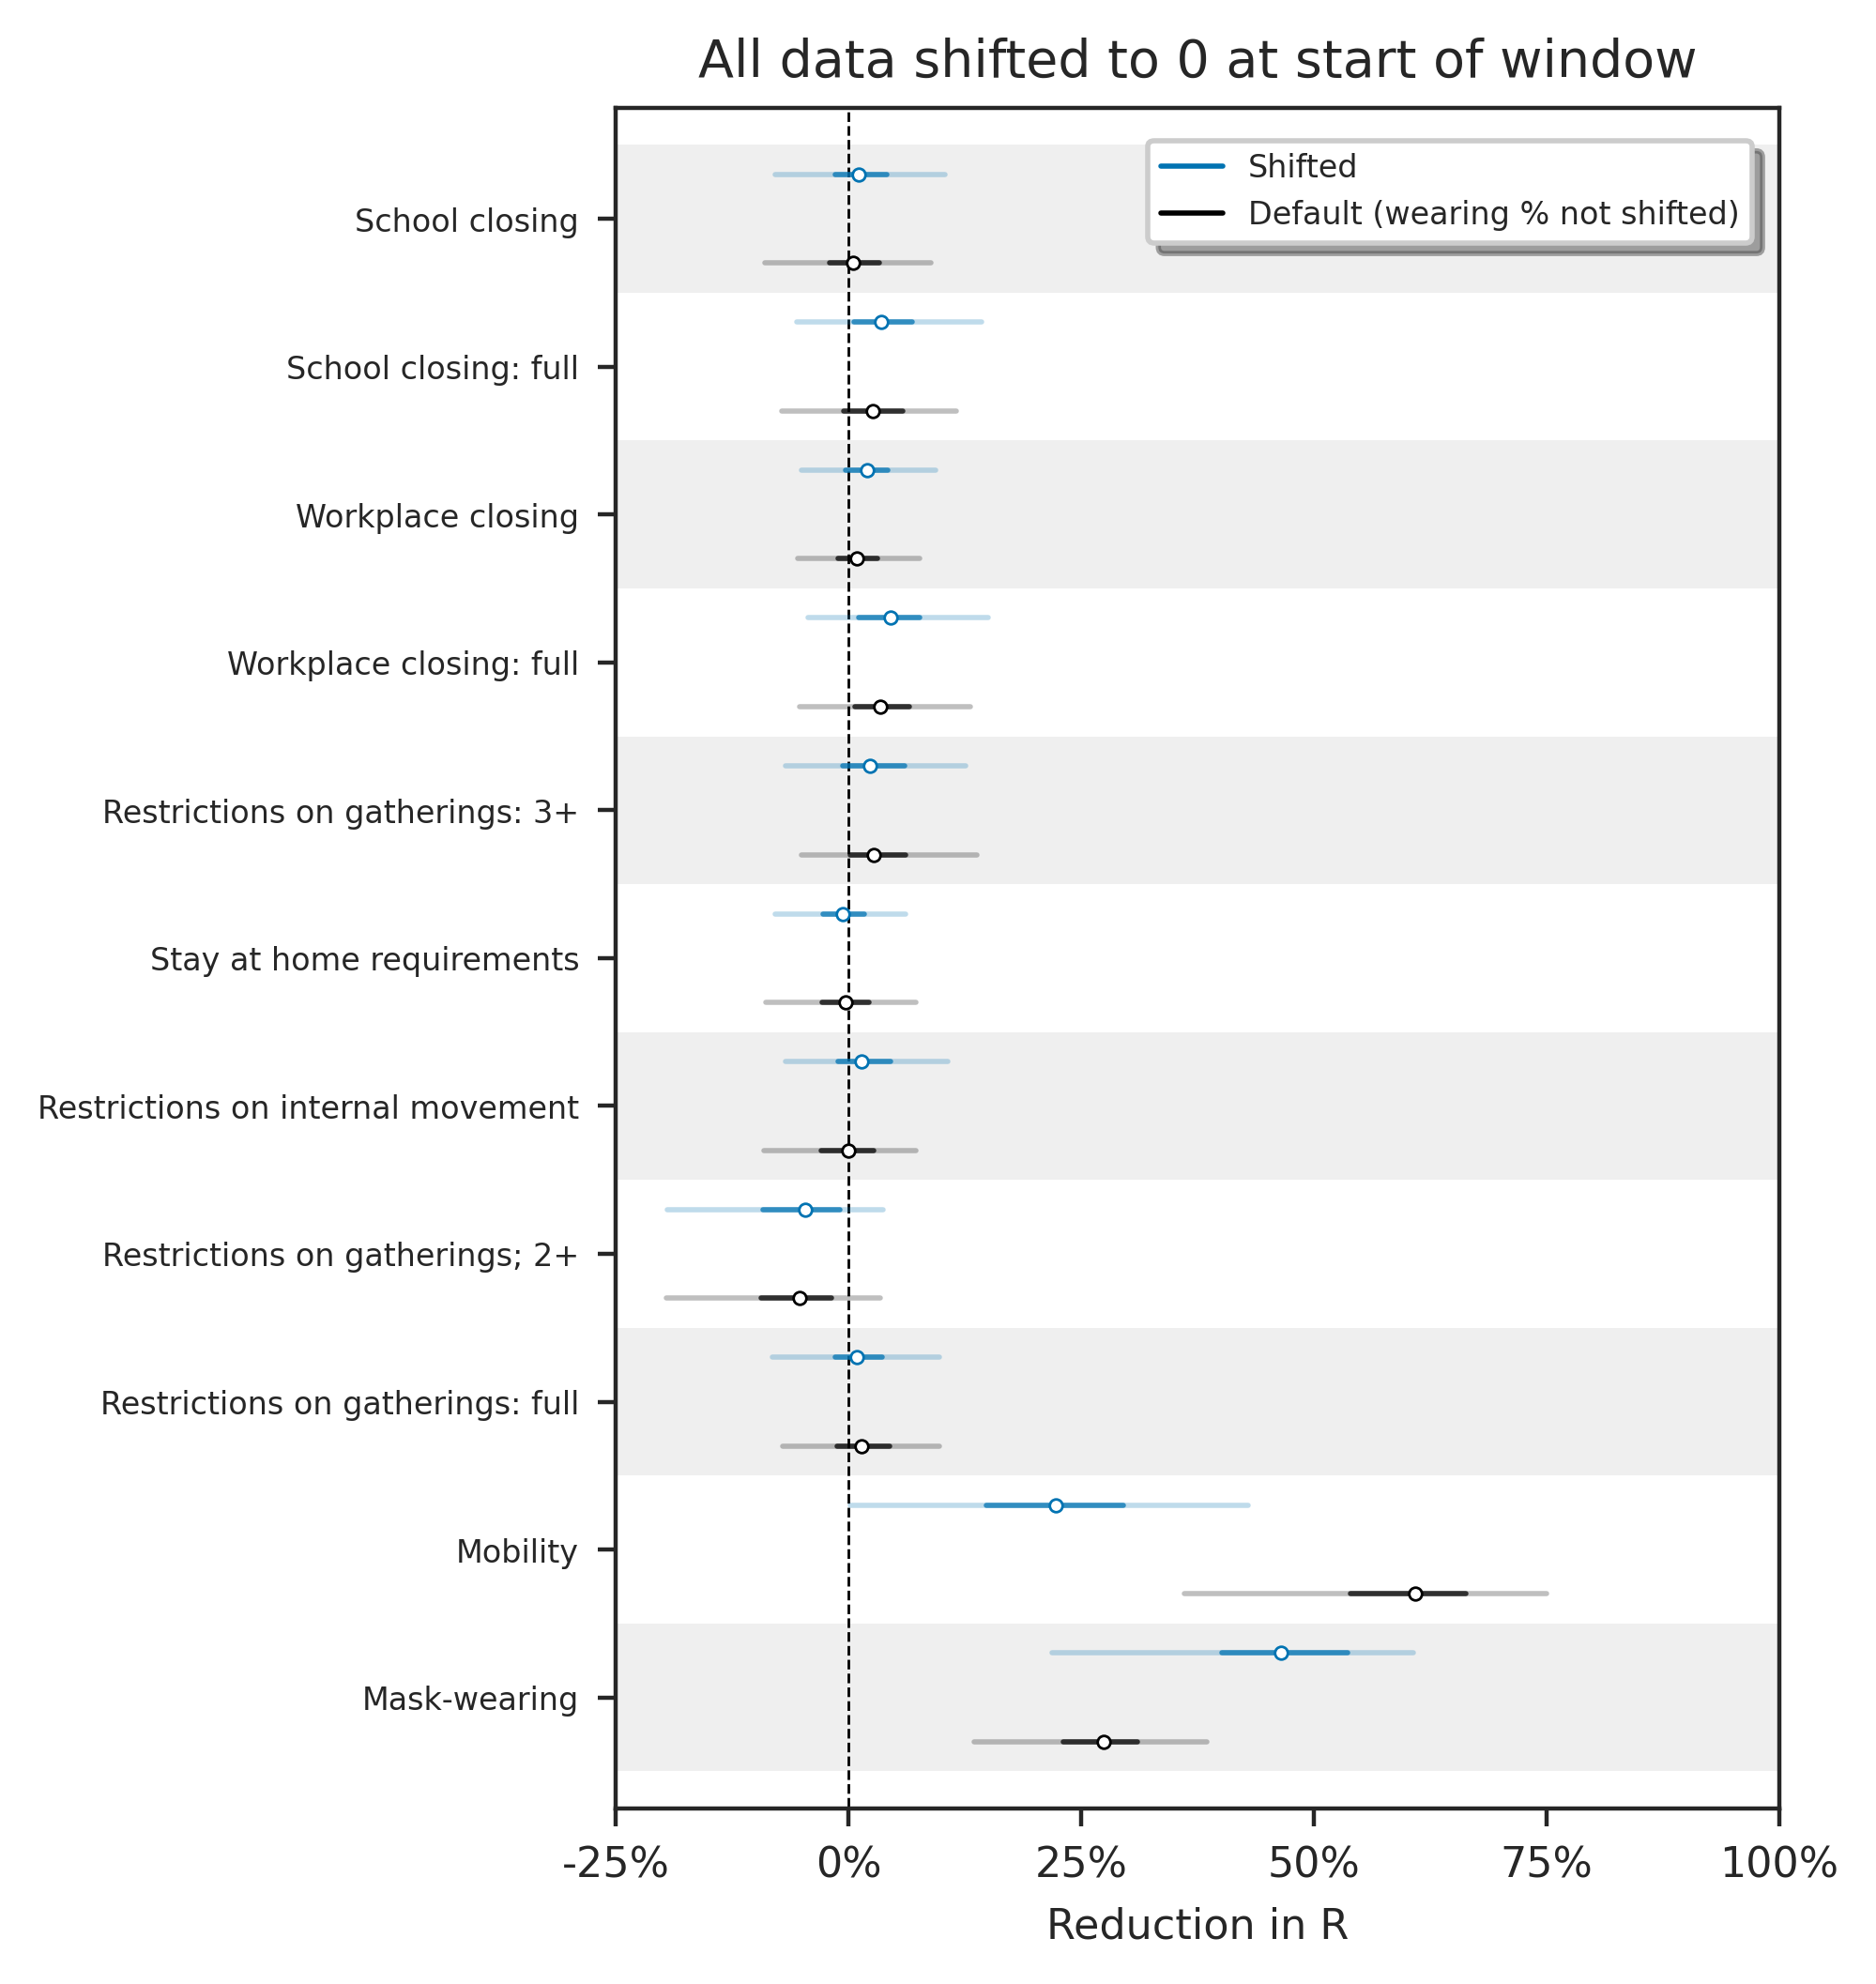

In [5]:
for category in categories:
    try:
        res_dir = base_dir + category
        all_experiments = get_all_experiments(res_dir)
        tags = get_unique_exp_tags(all_experiments)
        len(all_experiments)
        experiment_classes = make_all_experiment_classes(all_experiments)

        for experiment_class in experiment_classes:
            if experiment_class.exp_info['tag'] == "default":
                continue
            else:
                plot_experiment_class(experiment_class, grouped_dict,
                                      (-25, 100), default_alpha, default_names)
                plt.show()

    except Exception as e:
        print(e)
        print(f'{category} not found')

In [6]:
# category = 'boostrap'
# res_dir = "../sensitivity_analysis/RW_mob_12_05/" + category
# all_experiments = get_all_experiments(res_dir)
# tags = get_unique_exp_tags(all_experiments)
# len(all_experiments)
# experiment_classes = make_all_experiment_classes(all_experiments)
#
# for experiment_class in experiment_classes:
#     if experiment_class.exp_info['tag'] == "default":
#         continue
#     else:
#         plot_experiment_class(experiment_class, grouped_npis,
#                               (-25, 100), default_alpha, default_names)
#         plt.show()


In [7]:
# getting the RW noise scale for the R_0 prior experiment class
# given experiment, find the approximate NS by calculating the variance? that'll do
#
# category = 'basic_R_prior_scale'
# res_dir = base_dir + category
# all_experiments = get_all_experiments(res_dir)
# tags = get_unique_exp_tags(all_experiments)
# len(all_experiments)
# experiment_classes = make_all_experiment_classes(all_experiments)


## Wearing parameterisation interpretation

In [8]:
# from scipy.stats import norm
#
# def exp_reduction(reduction, x):
#     sample = -1.0 * np.log(reduction)
#     return np.exp(-1.0 * sample * x)
#
# def log_linear_reduction(reduction, x):
#     sample = 1.0 - reduction
#     return np.maximum(1.0 - (sample * x), 0)
#
# # def log_quadratic_reduction(reduction, x):
# #     return np.maximum(1.0 - sample[0] * x - sample[1] * x**2, 0)
#
# wearing_funs = [exp_reduction, log_linear_reduction]
#
# def get_parameter_quantiles(parameter_samples):
#     med = np.median(parameter_samples, axis=0)
#     li, lq, uq, ui = np.percentile(parameter_samples, [2.5, 25, 75, 97.5], axis=0)
#     # print(li, med, ui)
#     return li, med, ui
#
# def plot_wearing_reduction(reductions, par_to_reduction_function):
#     x = np.linspace(0,1,1000)
#     li = np.zeros(1000)
#     med = np.zeros(1000)
#     ui = np.zeros(1000)
#     for i in range(len(x)):
#         reductions_x = par_to_reduction_function(reductions, x[i])
#         li[i], med[i], ui[i] = get_parameter_quantiles(reductions_x)
#     plt.plot(x, med, label="Predicted Cases", color="tab:blue")
#     plt.fill_between(x, li, ui, alpha=0.1, color="tab:blue", linewidth=0)
#     plt.show()
#
# # def plot_quadratic_reduction()
#
# alphas = norm.rvs(0, 0.3, 10000)
# for fun in wearing_funs:
#     plot_wearing_reduction(alphas, fun)

In [9]:
# category = 'wearing_parameterisation'
# res_dir = "../sensitivity_analysis/RW_mob_12_05/" + category
# all_experiments = get_all_experiments(res_dir)
# w_par_experiment_classes = make_all_experiment_classes(all_experiments)

In [10]:
# reductions_exp = default_res['WearingReduction']
# reductions_log_linear = w_par_experiment_classes[0].experiments[0]['WearingReduction']
# for fun in wearing_funs:
#     plot_wearing_reduction(posterior_samples_exp, fun)


In [11]:
# import pandas as pd
# big_data = pd.read_csv('../../data/modelling_set/master_data_mob_include_us_True_m_w.csv')